In [1]:
%load_ext lab_black

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.io as sio
from scipy import stats
from theano import tensor as tt

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
az.style.use("arviz-darkgrid")

# Chapter 18 - Heuristic decision-making

## 18.1 Take-the-best
The take-the-best (TTB) model of decision-making (Gigerenzer & Goldstein, 1996) is a simple but influential account of how people choose between two stimuli on some criterion, and a good example of the general class of heuristic decision-making models (e.g., Gigerenzer & Todd, 1999; Gigerenzer & Gaissmaier, 2011; Payne, Bettman, & Johnson, 1990).


$$ t_q = \text{TTB}_{s}(\mathbf a_q,\mathbf b_q)$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_q = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_q = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

In [4]:
matdata = sio.loadmat("data/StopSearchData.mat")

y = np.squeeze(matdata["y"])
m = np.squeeze(np.float32(matdata["m"]))
p = np.squeeze(matdata["p"])
v = np.squeeze(np.float32(matdata["v"]))
x = np.squeeze(np.float32(matdata["x"]))

# Constants
n, nc = np.shape(m)  # number of stimuli and cues
nq, _ = np.shape(p)  # number of questions
ns, _ = np.shape(y)  # number of subjects

In [5]:
s = np.argsort(v)  # s[1:nc] <- rank(v[1:nc])
t = []
# TTB Model For Each Question
for q in range(nq):
    # Add Cue Contributions To Mimic TTB Decision
    tmp1 = np.zeros(nc)
    for j in range(nc):
        tmp1[j] = (m[p[q, 0] - 1, j] - m[p[q, 1] - 1, j]) * np.power(2, s[j])
    # Find if Cue Favors First, Second, or Neither Stimulus
    tmp2 = np.sum(tmp1)
    tmp3 = -1 * np.float32(-tmp2 > 0) + np.float32(tmp2 > 0)
    t.append(tmp3 + 1)

t = np.asarray(t, dtype=int)
tmat = np.tile(t[np.newaxis, :], (ns, 1))

<ipython-input-6-d8e410bb5f64>:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace1 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gamma]


/opt/anaconda3/lib/python3.8/site-packages/theano/scalar/basic.py:2851: RuntimeWarning: divide by zero encountered in true_divide
  return np.float32(1.0) / x
/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/lib/python3.8/site-packages/theano/scalar/basic.py:3023: RuntimeWarning: divide by zero encountered in log1p
  return np.log1p(x)
/opt/anaconda3/lib/python3.8/site-packages/theano/scalar/basic.py:1813: RuntimeWarning: invalid value encountered in double_scalars
  return sum(inputs)


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2044 seconds.
/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


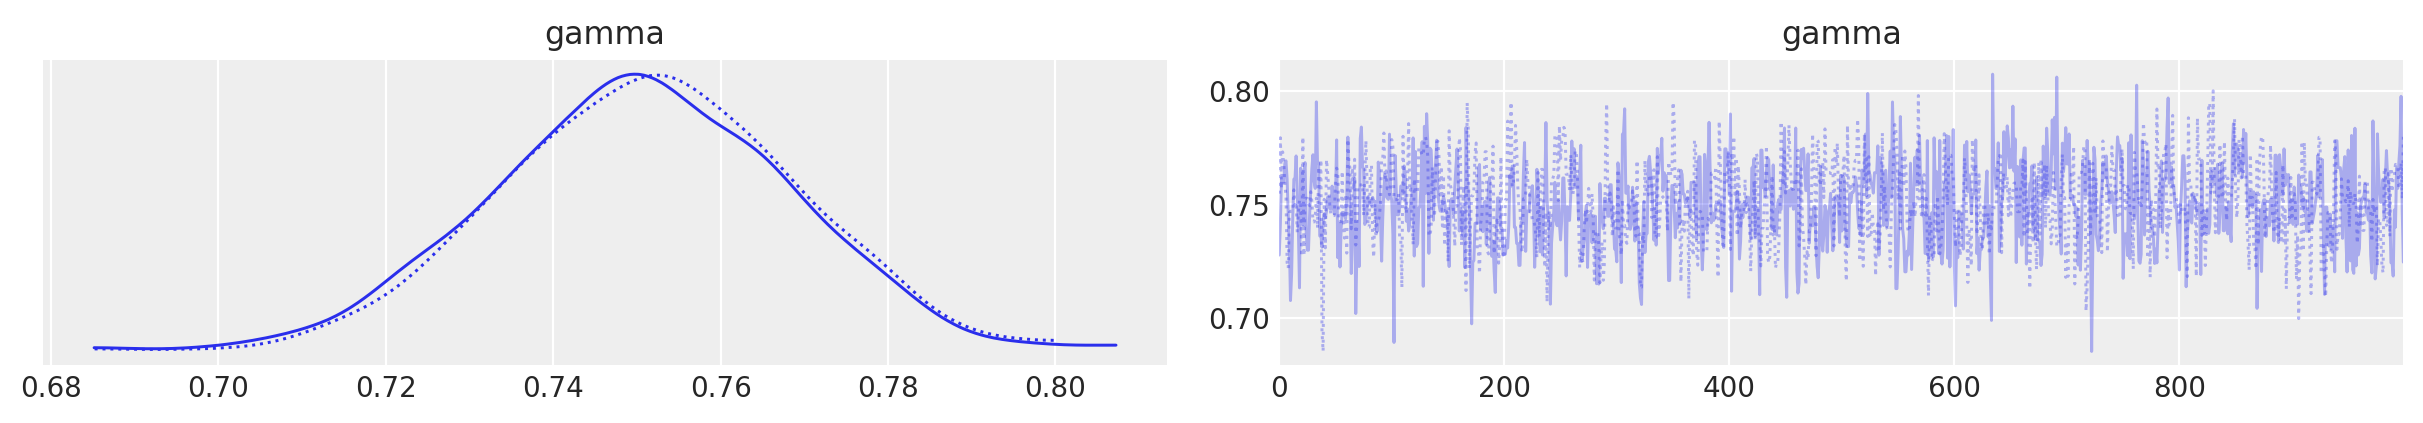

In [6]:
with pm.Model() as model1:
    gamma = pm.Uniform("gamma", lower=0.5, upper=1)
    gammat = tt.stack([1 - gamma, 0.5, gamma])

    yiq = pm.Bernoulli("yiq", p=gammat[tmat], observed=y)
    trace1 = pm.sample()

az.plot_trace(trace1)

/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


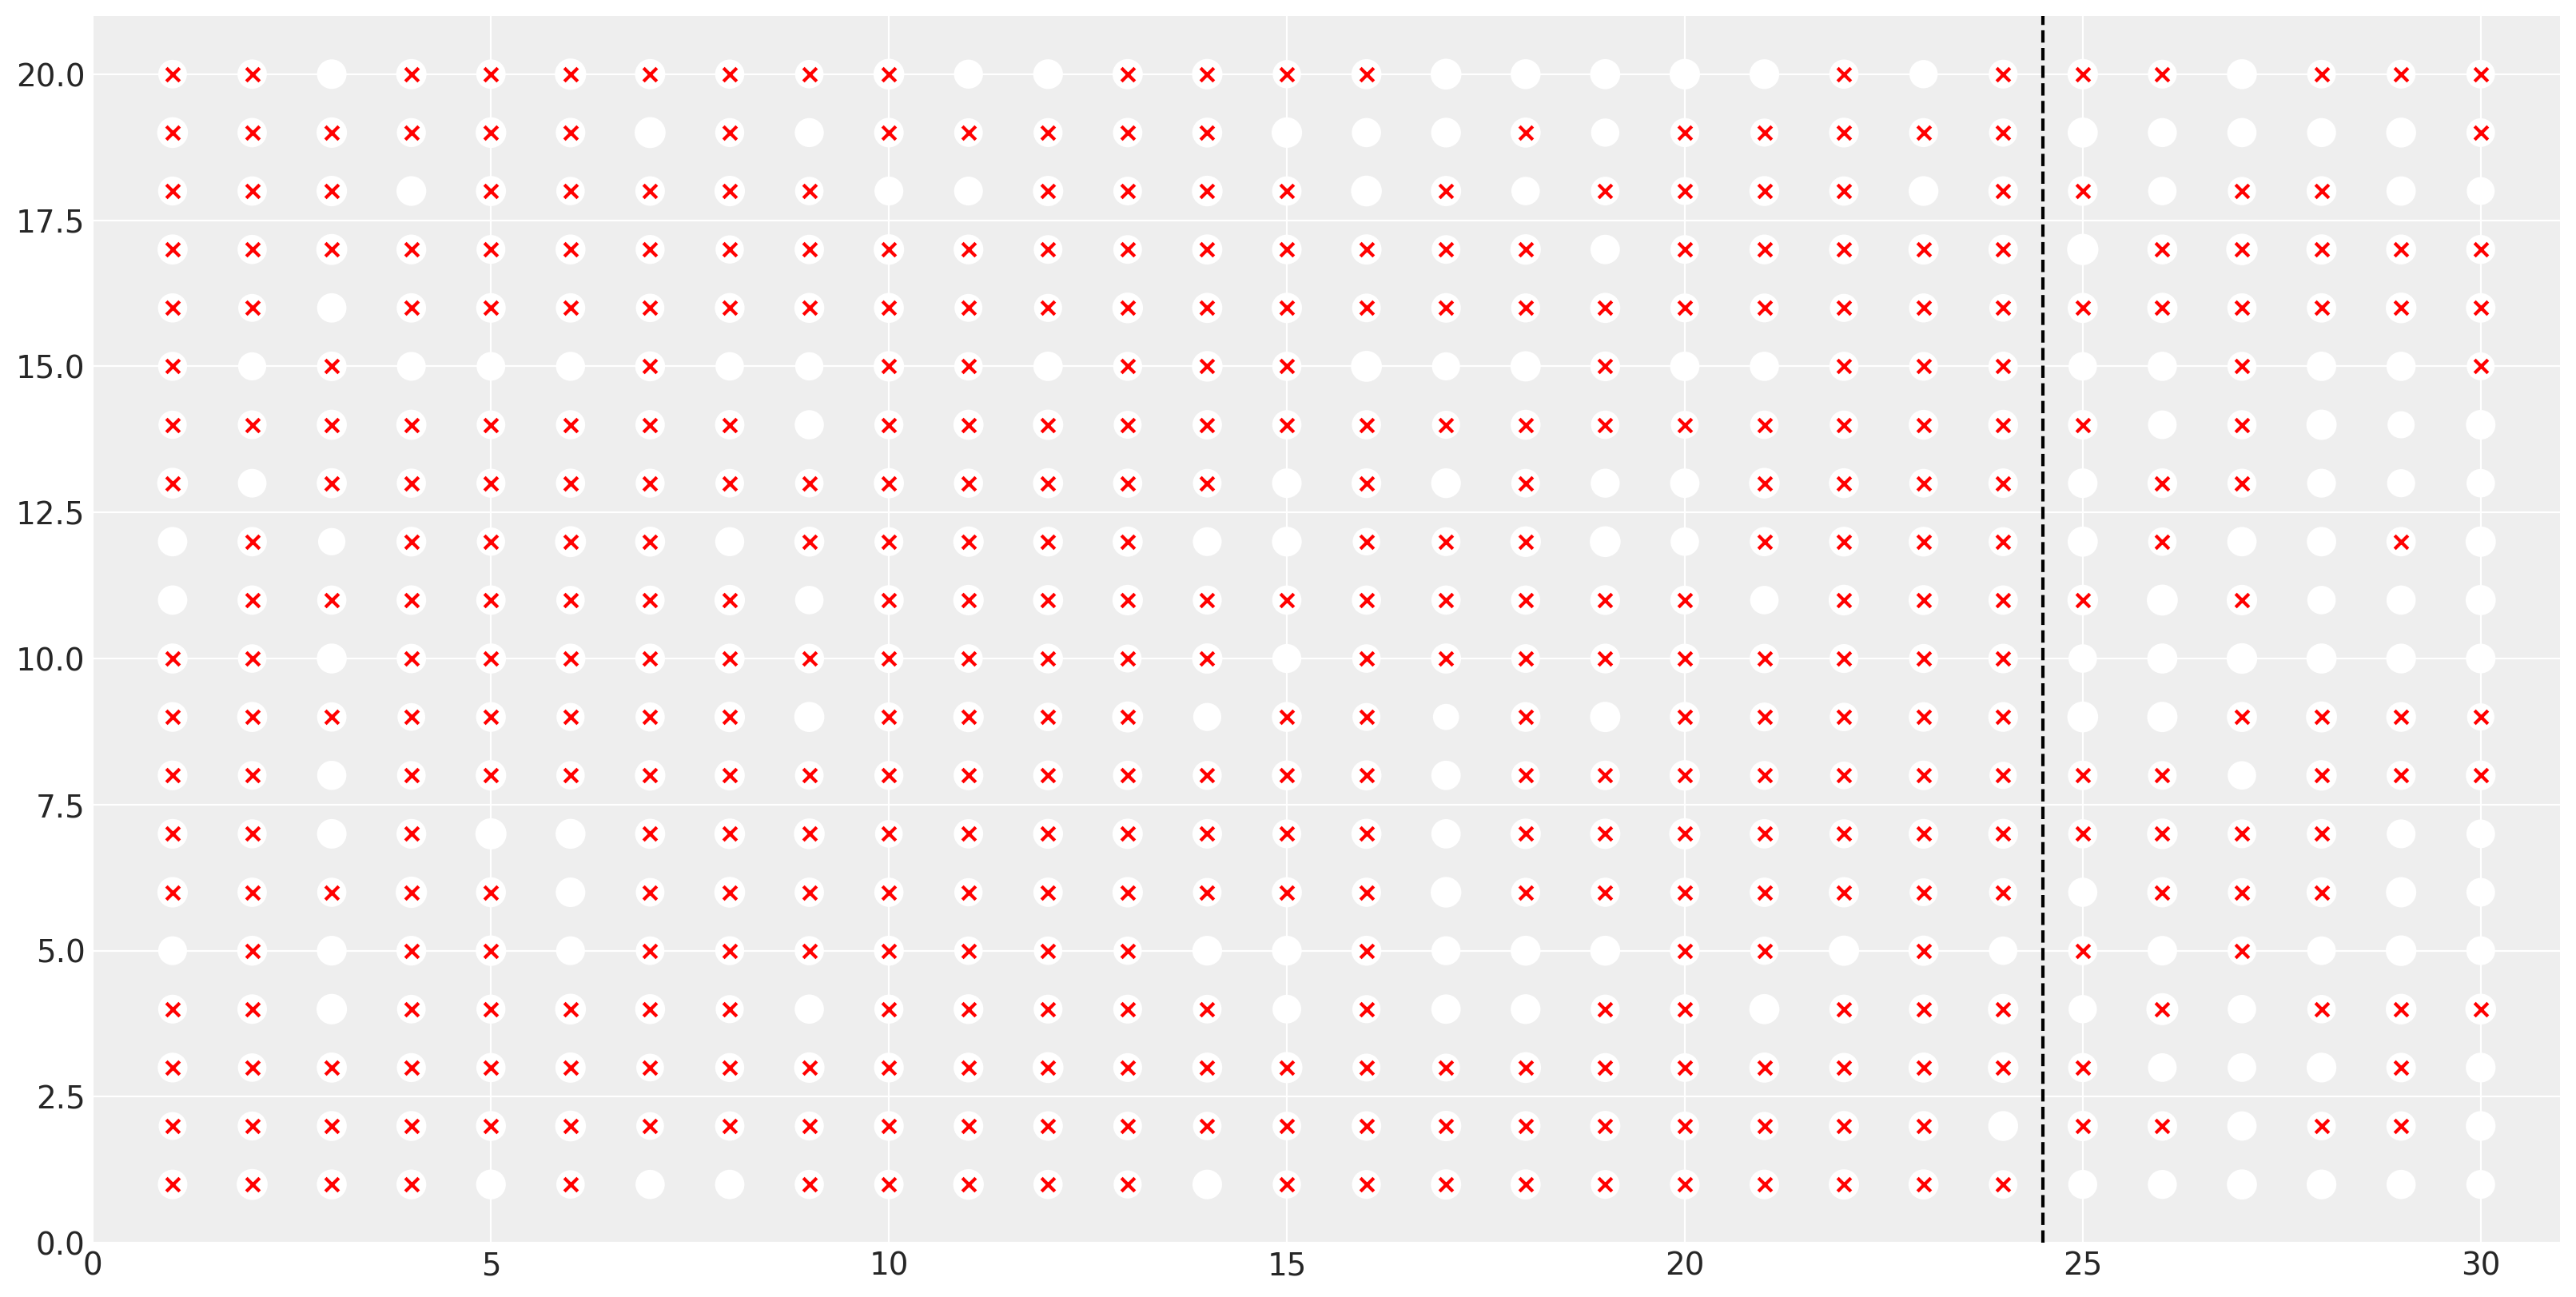

In [7]:
ppc = pm.sample_posterior_predictive(trace1, samples=100, model=model1)

yiqpred = np.asarray(ppc["yiq"])
fig = plt.figure(figsize=(16, 8))
x1 = np.repeat(np.arange(ns) + 1, nq).reshape(ns, -1).flatten()
y1 = np.repeat(np.arange(nq) + 1, ns).reshape(nq, -1).T.flatten()

plt.scatter(y1, x1, s=np.mean(yiqpred, axis=0) * 200, c="w")
plt.scatter(y1[y.flatten() == 1], x1[y.flatten() == 1], marker="x", c="r")
plt.plot(np.ones(100) * 24.5, np.linspace(0, 21, 100), "--", lw=1.5, c="k")
plt.axis([0, 31, 0, 21])

## 18.2 Stopping
A common comparison (e.g., Bergert & Nosofsky, 2007; Lee & Cummins, 2004) is between TTB and a model often called the Weighted ADDitive (WADD) model, which sums the evidence for both decision alternatives over all available cues, and chooses the one with the greatest evidence.

$$ \phi \sim \text{Uniform}(0,1)$$
$$ z_i \sim \text{Bernoulli}(\phi)$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ t_{iq} = 
\begin{cases}
\text{TTB}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_i = 1$} \\
\text{WADD}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_i = 0$} \\
\end{cases}  $$  

$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_{iq} = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_{iq} = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

In [8]:
# Question cue contributions template
qcc = np.zeros((nq, nc))
for q in range(nq):
    # Add Cue Contributions To Mimic TTB Decision
    for j in range(nc):
        qcc[q, j] = m[p[q, 0] - 1, j] - m[p[q, 1] - 1, j]

qccmat = np.tile(qcc[np.newaxis, :, :], (ns, 1, 1))
# TTB Model For Each Question
s = np.argsort(v)  # s[1:nc] <- rank(v[1:nc])
smat = np.tile(s[np.newaxis, :], (ns, nq, 1))
ttmp = np.sum(qccmat * np.power(2, smat), axis=2)
tmat = -1 * (-ttmp > 0) + (ttmp > 0) + 1
t = tmat[0]
# tmat = np.tile(t[np.newaxis, :], (ns, 1))

# WADD Model For Each Question
xmat = np.tile(x[np.newaxis, :], (ns, nq, 1))
wtmp = np.sum(qccmat * xmat, axis=2)
wmat = -1 * (-wtmp > 0) + (wtmp > 0) + 1
w = wmat[0]

t, w

(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 0, 0, 0, 0, 0]))

In [ ]:
with pm.Model() as model2:
    phi = pm.Beta("phi", alpha=1, beta=1, testval=0.01)

    zi = pm.Bernoulli(
        "zi",
        p=phi,
        shape=ns,
        testval=np.asarray(
            [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        ),
    )
    zi_ = tt.reshape(tt.repeat(zi, nq), (ns, nq))

    gamma = pm.Uniform("gamma", lower=0.5, upper=1)
    gammat = tt.stack([1 - gamma, 0.5, gamma])

    t2 = tt.switch(tt.eq(zi_, 1), tmat, wmat)
    yiq = pm.Bernoulli("yiq", p=gammat[t2], observed=y)

    trace2 = pm.sample()

az.plot_trace(trace2, compact=True);

<ipython-input-9-c02211c4c18e>:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace2 = pm.sample()
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [gamma, phi]
>BinaryGibbsMetropolis: [zi]


/opt/anaconda3/lib/python3.8/site-packages/theano/scalar/basic.py:2851: RuntimeWarning: divide by zero encountered in true_divide
  return np.float32(1.0) / x
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/lib/python3.8/site-packages/theano/scalar/basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


In [ ]:
fig = plt.figure(figsize=(16, 4))
zitrc = trace2["zi"]
plt.bar(np.arange(ns) + 1, 1 - np.mean(zitrc, axis=0))
plt.yticks([0, 1], ("TTB", "WADD"))
plt.xlabel("Subject")
plt.ylabel("Group")
plt.axis([0, 21, 0, 1]);

## 18.3 Searching


$$ s_i \sim \text{Uniform}((1,...,9),...,(9,...,1))$$
$$ t_{iq} = \text{TTB}_{si}(\mathbf a_q,\mathbf b_q)$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_{iq} = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_{iq} = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

In [ ]:
with pm.Model() as model3:
    gamma = pm.Uniform("gamma", lower=0.5, upper=1)
    gammat = tt.stack([1 - gamma, 0.5, gamma])

    v1 = pm.HalfNormal("v1", sd=1, shape=ns * nc)
    s1 = pm.Deterministic("s1", tt.argsort(v1.reshape((ns, 1, nc)), axis=2))
    smat2 = tt.tile(s1, (1, nq, 1))  # s[1:nc] <- rank(v[1:nc])

    # TTB Model For Each Question
    ttmp = tt.sum(qccmat * tt.power(2, smat2), axis=2)
    tmat = -1 * (-ttmp > 0) + (ttmp > 0) + 1

    yiq = pm.Bernoulli("yiq", p=gammat[tmat], observed=y)

It is important to notice here that, the sorting operation `s[1:nc] <- rank(v[1:nc])` is likely breaks the smooth property in geometry. Method such as NUTS and ADVI is likely return wrong estimation as the nasty geometry will lead the sampler to stuck in some local miminal.  
For this reason, we use Metropolis to sample from this model.

In [ ]:
with model3:
    trace3 = pm.sample(100_000, step=pm.Metropolis(), compute_convergence_checks=False)

az.plot_trace(trace3, var_names=["gamma", "v1"], compact=True);

In [ ]:
burnin = 50_000
# v1trace = np.squeeze(trace3['v1'][burnin:])
# s1trace = np.argsort(v1trace, axis=2)
s1trace = np.squeeze(trace3[burnin:]["s1"])

for subj_id in [12, 13]:
    subj_s = np.squeeze(s1trace[:, subj_id - 1, :])
    unique_ord = np.vstack({tuple(row) for row in subj_s})
    num_display = 10
    print("Subject %s" % (subj_id))
    print(
        "There are %s search orders sampled in the posterior." % (unique_ord.shape[0])
    )

    mass_ = []
    for s_ in unique_ord:
        mass_.append(np.mean(np.sum(subj_s == s_, axis=1) == len(s_)))
    mass_ = np.asarray(mass_)
    sortmass = np.argsort(mass_)[::-1]

    for i in sortmass[:num_display]:
        s_ = unique_ord[i]
        print("Order=(" + str(s_ + 1) + "), Estimated Mass=" + str(mass_[i]))

The return order is not at all similar to the result in JAGS (as shown in the book on p.233).

## 18.4 Searching and stopping


$$ \phi_{i} \sim \text{Uniform}(0,1)$$
$$ z_{iq} \sim \text{Bernoulli}(\phi_{i})$$
$$ s_i \sim \text{Uniform}((1,...,9),...,(9,...,1))$$
$$ \gamma \sim \text{Uniform}(0.5,1)$$  
$$ t_{iq} = 
\begin{cases}
\text{TTB}_{si}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_{iq} = 1$} \\
\text{WADD}\,(\mathbf a_q,\mathbf b_q) & \text{if $z_{iq} = 0$} \\
\end{cases}  $$  
$$ y_{iq} \sim
\begin{cases}
\text{Bernoulli}(\gamma) & \text{if $t_{iq} = a$} \\
\text{Bernoulli}(1- \gamma) & \text{if $t_{iq} = b$} \\
\text{Bernoulli}(0.5) & \text{otherwise}
\end{cases}  $$

In [ ]:
with pm.Model() as model4:
    phi = pm.Beta("phi", alpha=1, beta=1, testval=0.01)

    zi = pm.Bernoulli(
        "zi",
        p=phi,
        shape=ns,
        testval=np.asarray(
            [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        ),
    )
    zi_ = tt.reshape(tt.repeat(zi, nq), (ns, nq))

    gamma = pm.Uniform("gamma", lower=0.5, upper=1)
    gammat = tt.stack([1 - gamma, 0.5, gamma])

    v1 = pm.HalfNormal("v1", sd=1, shape=ns * nc)
    s1 = pm.Deterministic("s1", tt.argsort(v1.reshape((ns, 1, nc)), axis=2))
    smat2 = tt.tile(s1, (1, nq, 1))  # s[1:nc] <- rank(v[1:nc])

    # TTB Model For Each Question
    ttmp = tt.sum(qccmat * tt.power(2, smat2), axis=2)
    tmat = -1 * (-ttmp > 0) + (ttmp > 0) + 1

    t2 = tt.switch(tt.eq(zi_, 1), tmat, wmat)
    yiq = pm.Bernoulli("yiq", p=gammat[t2], observed=y)

    step = pm.Metropolis()
    trace4 = pm.sample(100_000, step=step, compute_convergence_checks=False)

burnin = 50_000
az.plot_trace(trace4[burnin:], var_names=["phi", "gamma"], compact=True);

In [ ]:
ppc = pm.sample_posterior_predictive(trace4[burnin:], samples=100, model=model4)

yiqpred = np.asarray(ppc["yiq"])
fig = plt.figure(figsize=(16, 8))
x1 = np.repeat(np.arange(ns) + 1, nq).reshape(ns, -1).flatten()
y1 = np.repeat(np.arange(nq) + 1, ns).reshape(nq, -1).T.flatten()

plt.scatter(y1, x1, s=np.mean(yiqpred, axis=0) * 200, c="w")
plt.scatter(y1[y.flatten() == 1], x1[y.flatten() == 1], marker="x", c="r")
plt.plot(np.ones(100) * 24.5, np.linspace(0, 21, 100), "--", lw=1.5, c="k")
plt.axis([0, 31, 0, 21])
plt.show()

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w